# Rudimentos de Machine Learning

![Colegio Bourbaki](./Images/Bourbaki.png)

## Clasificación Multiclase

### Análisis Exploratorio

### Contexto

La mayoría de los mercados financieros utilizan un mecanismo de negociación electrónica denominado libro de órdenes limitadas para facilitar la negociación de activos (acciones, futuros, opciones, etc.). Los participantes envían (o cancelan) órdenes a este libro de órdenes electrónico. Estas órdenes son solicitudes de compra o venta de una cantidad determinada de un activo a un precio especificado, lo que permite emparejar a compradores con vendedores a un precio mutuamente acordado. Dado que un activo puede negociarse en varios centros de negociación, los participantes pueden elegir a qué centro envían una orden. Por ejemplo, una acción estadounidense puede negociarse en varias bolsas, como NYSE, NASDAQ, Direct Edge o BATS. Al enviar una orden, los participantes suelen seleccionar el mejor centro de negociación disponible en ese momento. Sus decisiones pueden incluir un análisis estadístico de la actividad anterior del centro.

**Objetivos del reto**

Dadas las últimas operaciones y los libros de órdenes de un conjunto de centros de negociación, predecir en qué centro de negociación se ejecutará la siguiente operación.

Para cada fila, queremos predecir en qué centro se ejecutará la siguiente operación. El valor se representa mediante un stock_id aleatorio y el día mediante un day_id aleatorio.

Cada fila proporciona una descripción de seis libros de órdenes, de seis centros de negociación, y un historial de operaciones para el activo correspondiente.

**Libros de órdenes**

En un libro de órdenes figuran las cantidades de un activo que ofrecen actualmente los vendedores (que piden precios más altos) y las cantidades que desean adquirir los compradores (que pujan a precios más bajos). Los seis libros de órdenes (uno por cada centro de negociación) se describen en el conjunto de datos a través de las dos mejores ofertas y las dos mejores demandas (que son, respectivamente, los dos precios de oferta más altos de los compradores y los dos precios de demanda más bajos de los vendedores).

Llamamos volumen agregado a la suma de todas las cantidades en los lados comprador y vendedor (considerando sólo las dos mejores ofertas y las dos mejores demandas) en los seis libros dados.

También definimos el precio medio agregado como la media de la mejor oferta entre los seis libros (es decir, el máximo de las seis mejores ofertas) y la mejor demanda entre los seis libros (es decir, el mínimo de las seis mejores demandas).

Cada uno de los seis libros se describe como sigue:

* La columna «bid» (respectivamente «ask») representa la diferencia entre la mejor oferta (respectivamente la mejor demanda) y el precio medio agregado, expresado en una unidad monetaria fija.

* La columna «bid1» (respectivamente «ask1») representa la diferencia entre la segunda mejor oferta (respectivamente la segunda mejor demanda) y el precio medio agregado, expresado en una unidad monetaria fija.

* La columna «bid_size» (respectivamente «ask_size») representa el número total de valores disponibles a la mejor oferta (respectivamente mejor demanda) dividido por el volumen agregado.

* La columna «bid_size1» (respectivamente «ask_size1») representa el número total de valores disponibles a la segunda mejor oferta (respectivamente a la segunda mejor demanda) dividido por el volumen total.

* La columna «ts_last_update» corresponde a la fecha y hora, expresada en microsegundos desde medianoche (hora local), de la última actualización del libro.

Un valor NAN indica un libro vacío o parcialmente vacío.

Tenga en cuenta que todos los precios se expresan en la misma unidad monetaria fija.

Además, como todos los centros de negociación pertenecen a la misma zona horaria, todas las marcas de tiempo tienen la misma referencia horaria.
Operaciones

Cada fila contiene también una descripción de las diez últimas operaciones (ordenadas de la más reciente a la más antigua) del activo correspondiente. Una operación representa una transacción de una cantidad determinada de un activo a un precio dado entre un comprador y un vendedor. La mayoría de las operaciones son el resultado de la correspondencia entre una orden de un libro de órdenes y una orden entrante, pero también pueden ser el resultado de un mecanismo de negociación diferente, como las subastas. Las operaciones suelen conllevar comisiones, pagadas por el comprador y el vendedor, que varían de un centro de negociación a otro. A continuación se describen las diez operaciones del historial de operaciones:

* Su cantidad ('qty'): el número de valores negociados, dividido por el volumen agregado (definido anteriormente en la sección «Libro de órdenes»).

* Su fecha y hora («tod»): el momento en que se ejecutó la operación, expresado en microsegundos desde medianoche (hora local).

* Su precio («price»), que representa la diferencia entre el precio de la operación y el precio medio agregado (definido en la sección «Cartera de órdenes»), expresado en alguna unidad monetaria fija.

* Su origen («source_id»), que representa el centro de negociación en el que se ejecutó esta operación concreta.

**Descripción de las etiquetas**

Las etiquetas corresponden a los centros de negociación que hay que predecir. Cada uno de los seis centros de negociación está representado por un número entre 0 y 5.

**Descripción del baseline**

El baseline consiste simplemente en tomar el centro de negociación de la operación más reciente en el historial

**Link del reto:** https://challengedata.ens.fr/participants/challenges/40/

### Librerías

In [1]:
# Data Analysis
import numpy as np
import pandas as pd
import missingno as msno

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Utils
import random

### Funciones de ayuda

In [17]:
def iqr_outlier_mask(x, k=1.5):
    """Return a boolean mask of outliers in x using the IQR rule."""
    q1, q3 = np.percentile(x.dropna(), [25, 75])
    iqr = q3 - q1
    lower, upper = q1 - k * iqr, q3 + k * iqr
    return (x < lower) | (x > upper)


def zscore_outlier_mask(x, thresh=3):
    """Return a boolean mask of outliers in x using |z| > thresh."""
    return ((x - x.mean()) / x.std()).abs() > thresh


def summarize_outliers(df, method="iqr", **method_kwargs):
    """
    Apply an outlier‐mask function to every numeric column in df.

    Parameters
    ----------
    df : pd.DataFrame
    method : {"iqr", "zscore"}
        Which rule to use.
    **method_kwargs :
        Passed to the mask function (e.g. k for IQR or thresh for zscore).

    Returns
    -------
    pd.DataFrame
        columns: ["column","n_outliers","pct_outliers"]
    """
    if method == "iqr":
        mask_fn = iqr_outlier_mask
    elif method == "zscore":
        mask_fn = zscore_outlier_mask
    else:
        raise ValueError("method must be 'iqr' or 'zscore'")

    summary = []
    for col in df.select_dtypes(include="number").columns:
        mask = mask_fn(df[col], **method_kwargs)
        n_out = int(mask.sum())
        pct_out = n_out / len(df) * 100
        summary.append({"column": col, "n_outliers": n_out, "pct_outliers": pct_out})

    return pd.DataFrame(summary).sort_values("pct_outliers", ascending=False)


In [3]:
def visualize_distributions(df, sample=None):
    """
    For each numeric column in df, plots:
      1) A boxplot
      2) A histogram (with 30 bins)
    """
    cols = list(df.select_dtypes(include="number").columns)
    if sample is not None and isinstance(sample, int) and sample < len(cols):
        cols = random.sample(cols, sample)
    for col in cols:
        # Boxplot
        plt.figure()
        plt.boxplot(df[col].dropna())
        plt.title(f"Boxplot of {col}")
        plt.ylabel(col)
        plt.show()

        # Histogram
        plt.figure()
        plt.hist(df[col].dropna(), bins=30)
        plt.title(f"Histogram of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.show()

### Carga de Datos

In [4]:
# Load the dataset
train = pd.read_hdf("./Data/train_dc2020.h5")

#### Data inicial

In [5]:
# Display the first few rows of each dataset to understand their structure
train.head()

,"(0, ask)","(0, ask1)","(0, ask_size)","(0, ask_size1)","(0, bid)","(0, bid1)","(0, bid_size)","(0, bid_size1)","(0, price)","(0, qty)",...,"(8, qty)","(8, source_id)","(8, tod)","(9, price)","(9, qty)","(9, source_id)","(9, tod)",stock_id,day_id,ID
0,4.5,562.5,0.002330,0.093197,-25.5,-545.5,0.046598,0.046598,-0.5,0.037279,...,0.004660,4,38930876675,-3.5,0.046598,2,38930876000,387,238,0
1,2.5,14.5,0.001314,0.013139,-10.5,-406.5,0.013139,0.026278,-0.5,0.013139,...,0.013139,2,46336088000,1.5,0.013139,4,46336087875,437,22,1
2,5.0,210.0,0.010792,0.010792,-95.0,-285.0,0.032376,0.021584,-3.0,0.010253,...,0.050615,2,57584792000,0.0,0.010792,2,57583312000,7,255,2
3,0.5,1.5,0.006943,0.006943,-2.5,-3.5,0.006943,0.013886,-0.5,0.000069,...,0.013886,4,49549010300,0.5,0.006943,1,49549010200,48,64,3
4,15.0,442.0,0.035689,0.071378,-391.0,-397.0,0.035689,0.035689,3.0,0.035689,...,0.035689,2,42452055000,-8.0,0.035689,3,42451072650,52,231,4


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 959506 entries, 0 to 959505
Data columns (total 97 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   (0, ask)             959487 non-null  float32
 1   (0, ask1)            959484 non-null  float32
 2   (0, ask_size)        959487 non-null  float32
 3   (0, ask_size1)       959484 non-null  float32
 4   (0, bid)             959488 non-null  float32
 5   (0, bid1)            959486 non-null  float32
 6   (0, bid_size)        959488 non-null  float32
 7   (0, bid_size1)       959486 non-null  float32
 8   (0, price)           959506 non-null  float32
 9   (0, qty)             959506 non-null  float32
 10  (0, source_id)       959506 non-null  int32  
 11  (0, tod)             959506 non-null  int64  
 12  (0, ts_last_update)  959506 non-null  int64  
 13  (1, ask)             959500 non-null  float32
 14  (1, ask1)            959492 non-null  float32
 15  (1, ask_size)        9

In [7]:
# Data types & memory usage
print(train.dtypes, "\n")
print(train.memory_usage(deep=True).sum() / 1024**2, "MB")

(0, ask)          float32
(0, ask1)         float32
(0, ask_size)     float32
(0, ask_size1)    float32
(0, bid)          float32
                   ...   
(9, source_id)      int32
(9, tod)            int64
stock_id            int64
day_id              int64
ID                  int64
Length: 97, dtype: object 

431.9065399169922 MB


### Análisis Univariado

In [10]:
# Basic summary statistics for numeric features
display(train.describe().T)

,count,mean,std,min,25%,50%,75%,max
"(0, ask)",959487.0,7.934715e+01,3.932770e+02,-5.000000e-01,2.500000e+00,7.500000e+00,1.700000e+01,1.017700e+04
"(0, ask1)",959484.0,3.131562e+02,6.344425e+02,1.500000e-02,7.500000e+00,1.605000e+02,4.120000e+02,1.327350e+04
"(0, ask_size)",959487.0,2.876814e-02,2.142036e-02,2.154067e-06,1.392336e-02,2.707093e-02,3.855050e-02,9.156311e-01
"(0, ask_size1)",959484.0,3.686660e-02,2.913393e-02,8.361553e-06,1.666389e-02,3.237294e-02,5.021341e-02,9.380876e-01
"(0, bid)",959488.0,-8.995106e+01,4.202793e+02,-1.014200e+04,-1.800000e+01,-7.500000e+00,-2.500000e+00,5.000000e-01
...,...,...,...,...,...,...,...,...
"(9, source_id)",959506.0,2.958547e+00,1.363040e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00
"(9, tod)",959506.0,4.729078e+10,7.659177e+09,3.420000e+10,4.023918e+10,4.755761e+10,5.495230e+10,5.759998e+10
stock_id,959506.0,2.460576e+02,1.468082e+02,0.000000e+00,1.180000e+02,2.420000e+02,3.740000e+02,4.990000e+02
day_id,959506.0,1.222493e+02,7.607254e+01,2.000000e+00,5.400000e+01,1.230000e+02,1.890000e+02,2.550000e+02


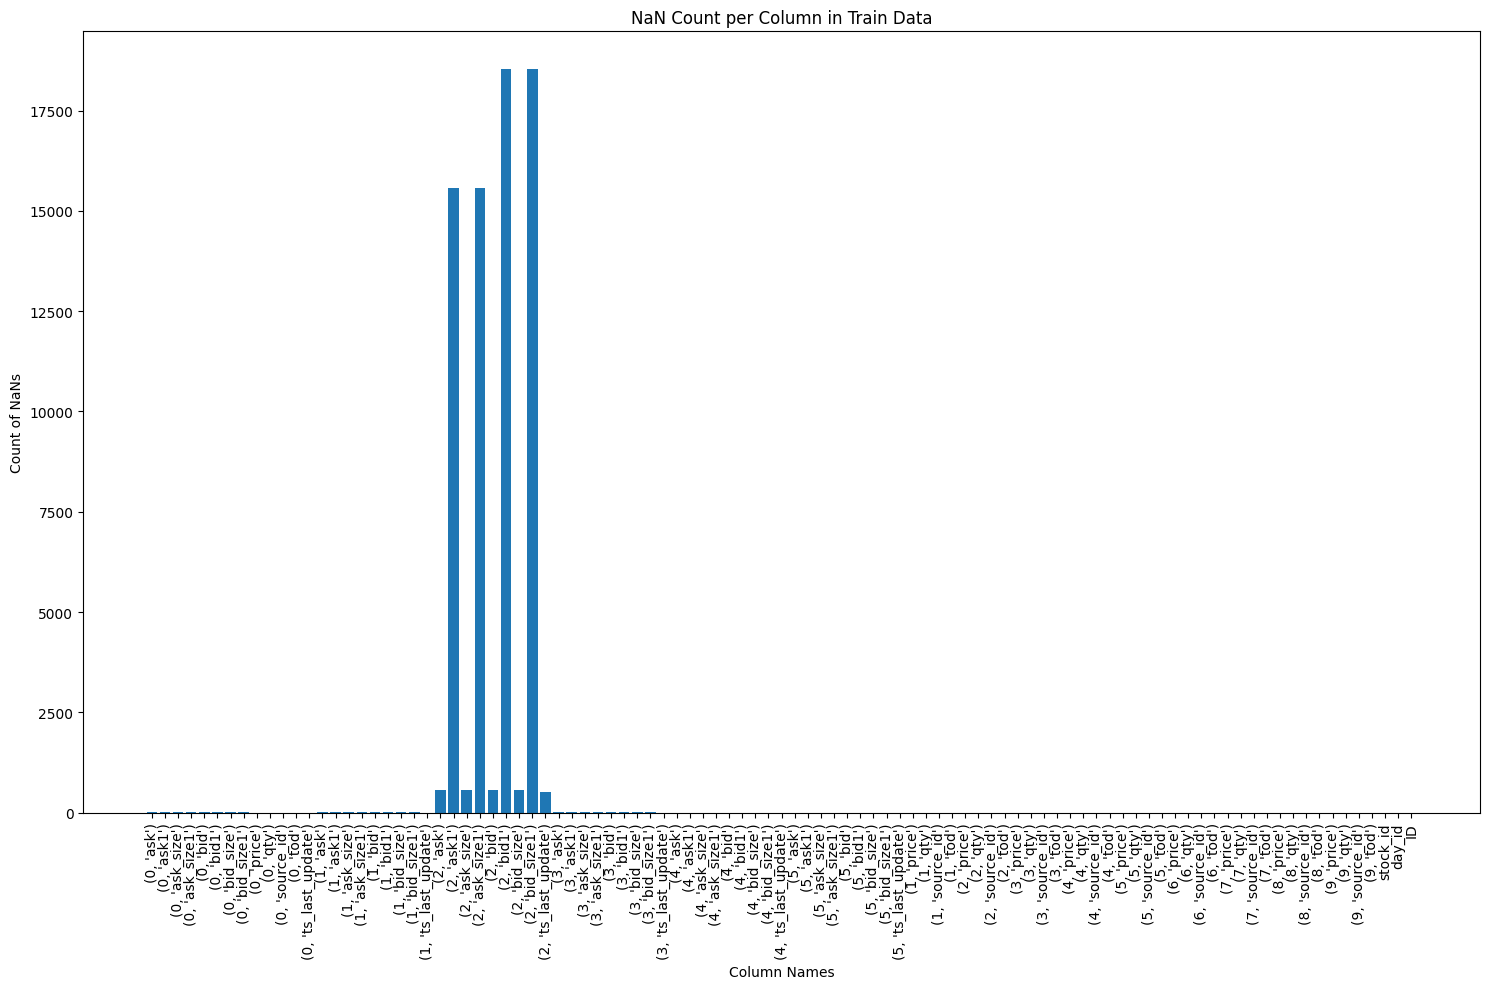

In [11]:
# Get the count of NaNs for each column
nan_counts = train.isna().sum()

# Create a numeric index for the x-axis
x = np.arange(len(train.columns))

plt.figure(figsize=(15, 10))
plt.bar(x, nan_counts)
plt.xticks(x, train.columns, rotation=90)
plt.xlabel("Column Names")
plt.ylabel("Count of NaNs")
plt.title("NaN Count per Column in Train Data")
plt.tight_layout()
plt.show()

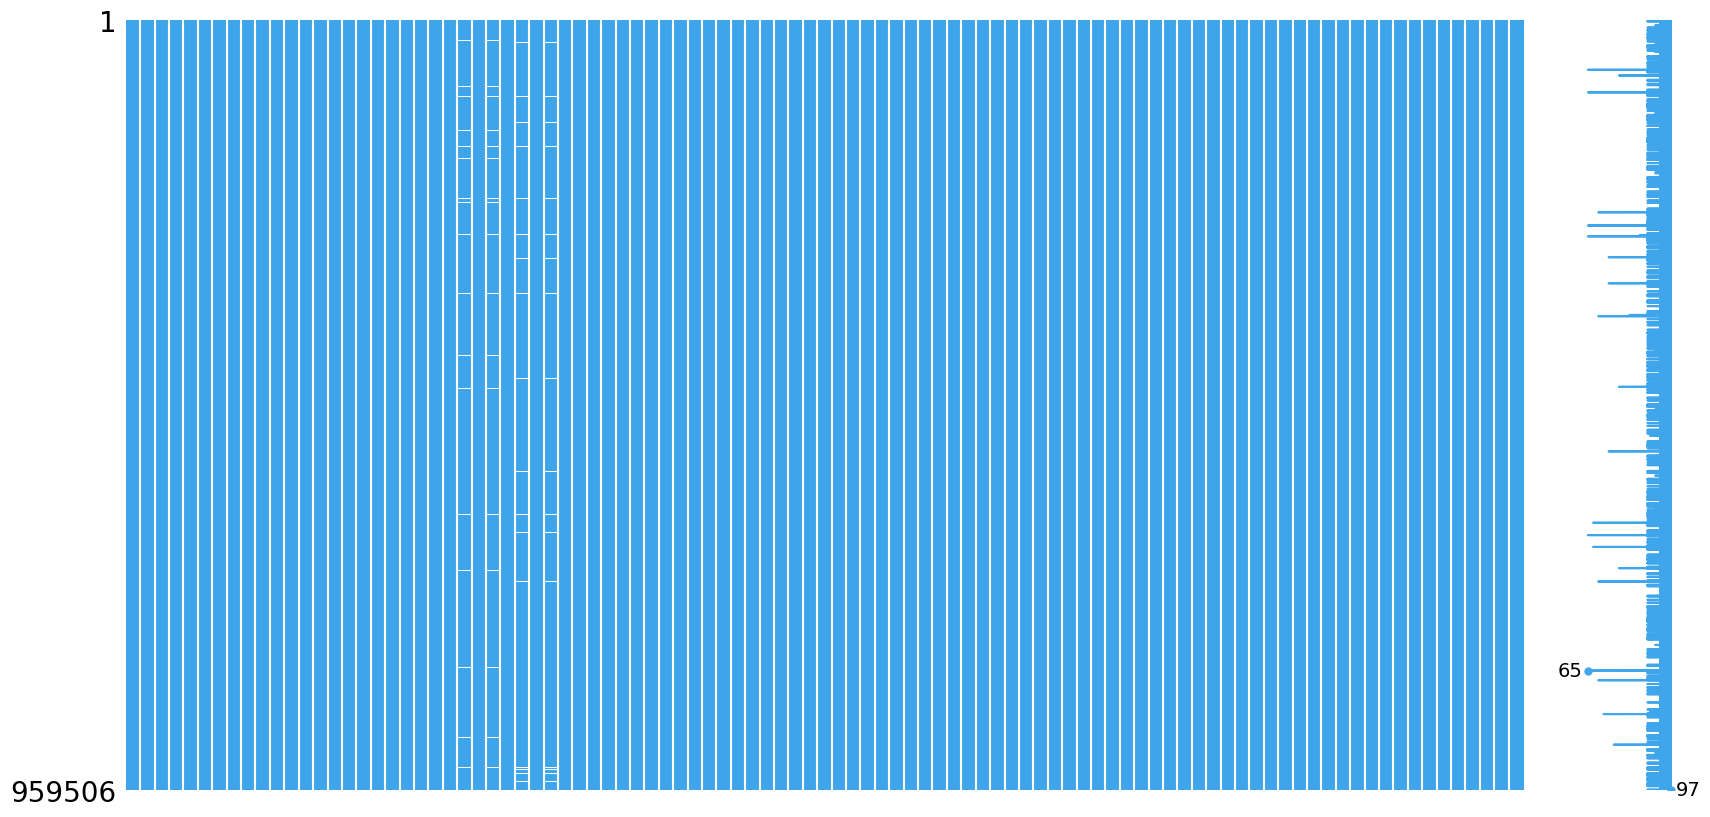

In [12]:
msno.matrix(train, figsize=(20, 10), color=(0.25, 0.65, 0.92))
plt.show()

La matriz de nulidad msno.matrix es una gráficos de datos densos que permiten detectar rápidamente patrones visuales.

El gráfico de la derecha resume la forma general de la exhaustividad de los datos y señala las filas con el máximo y el mínimo de nulidad en el conjunto de datos.

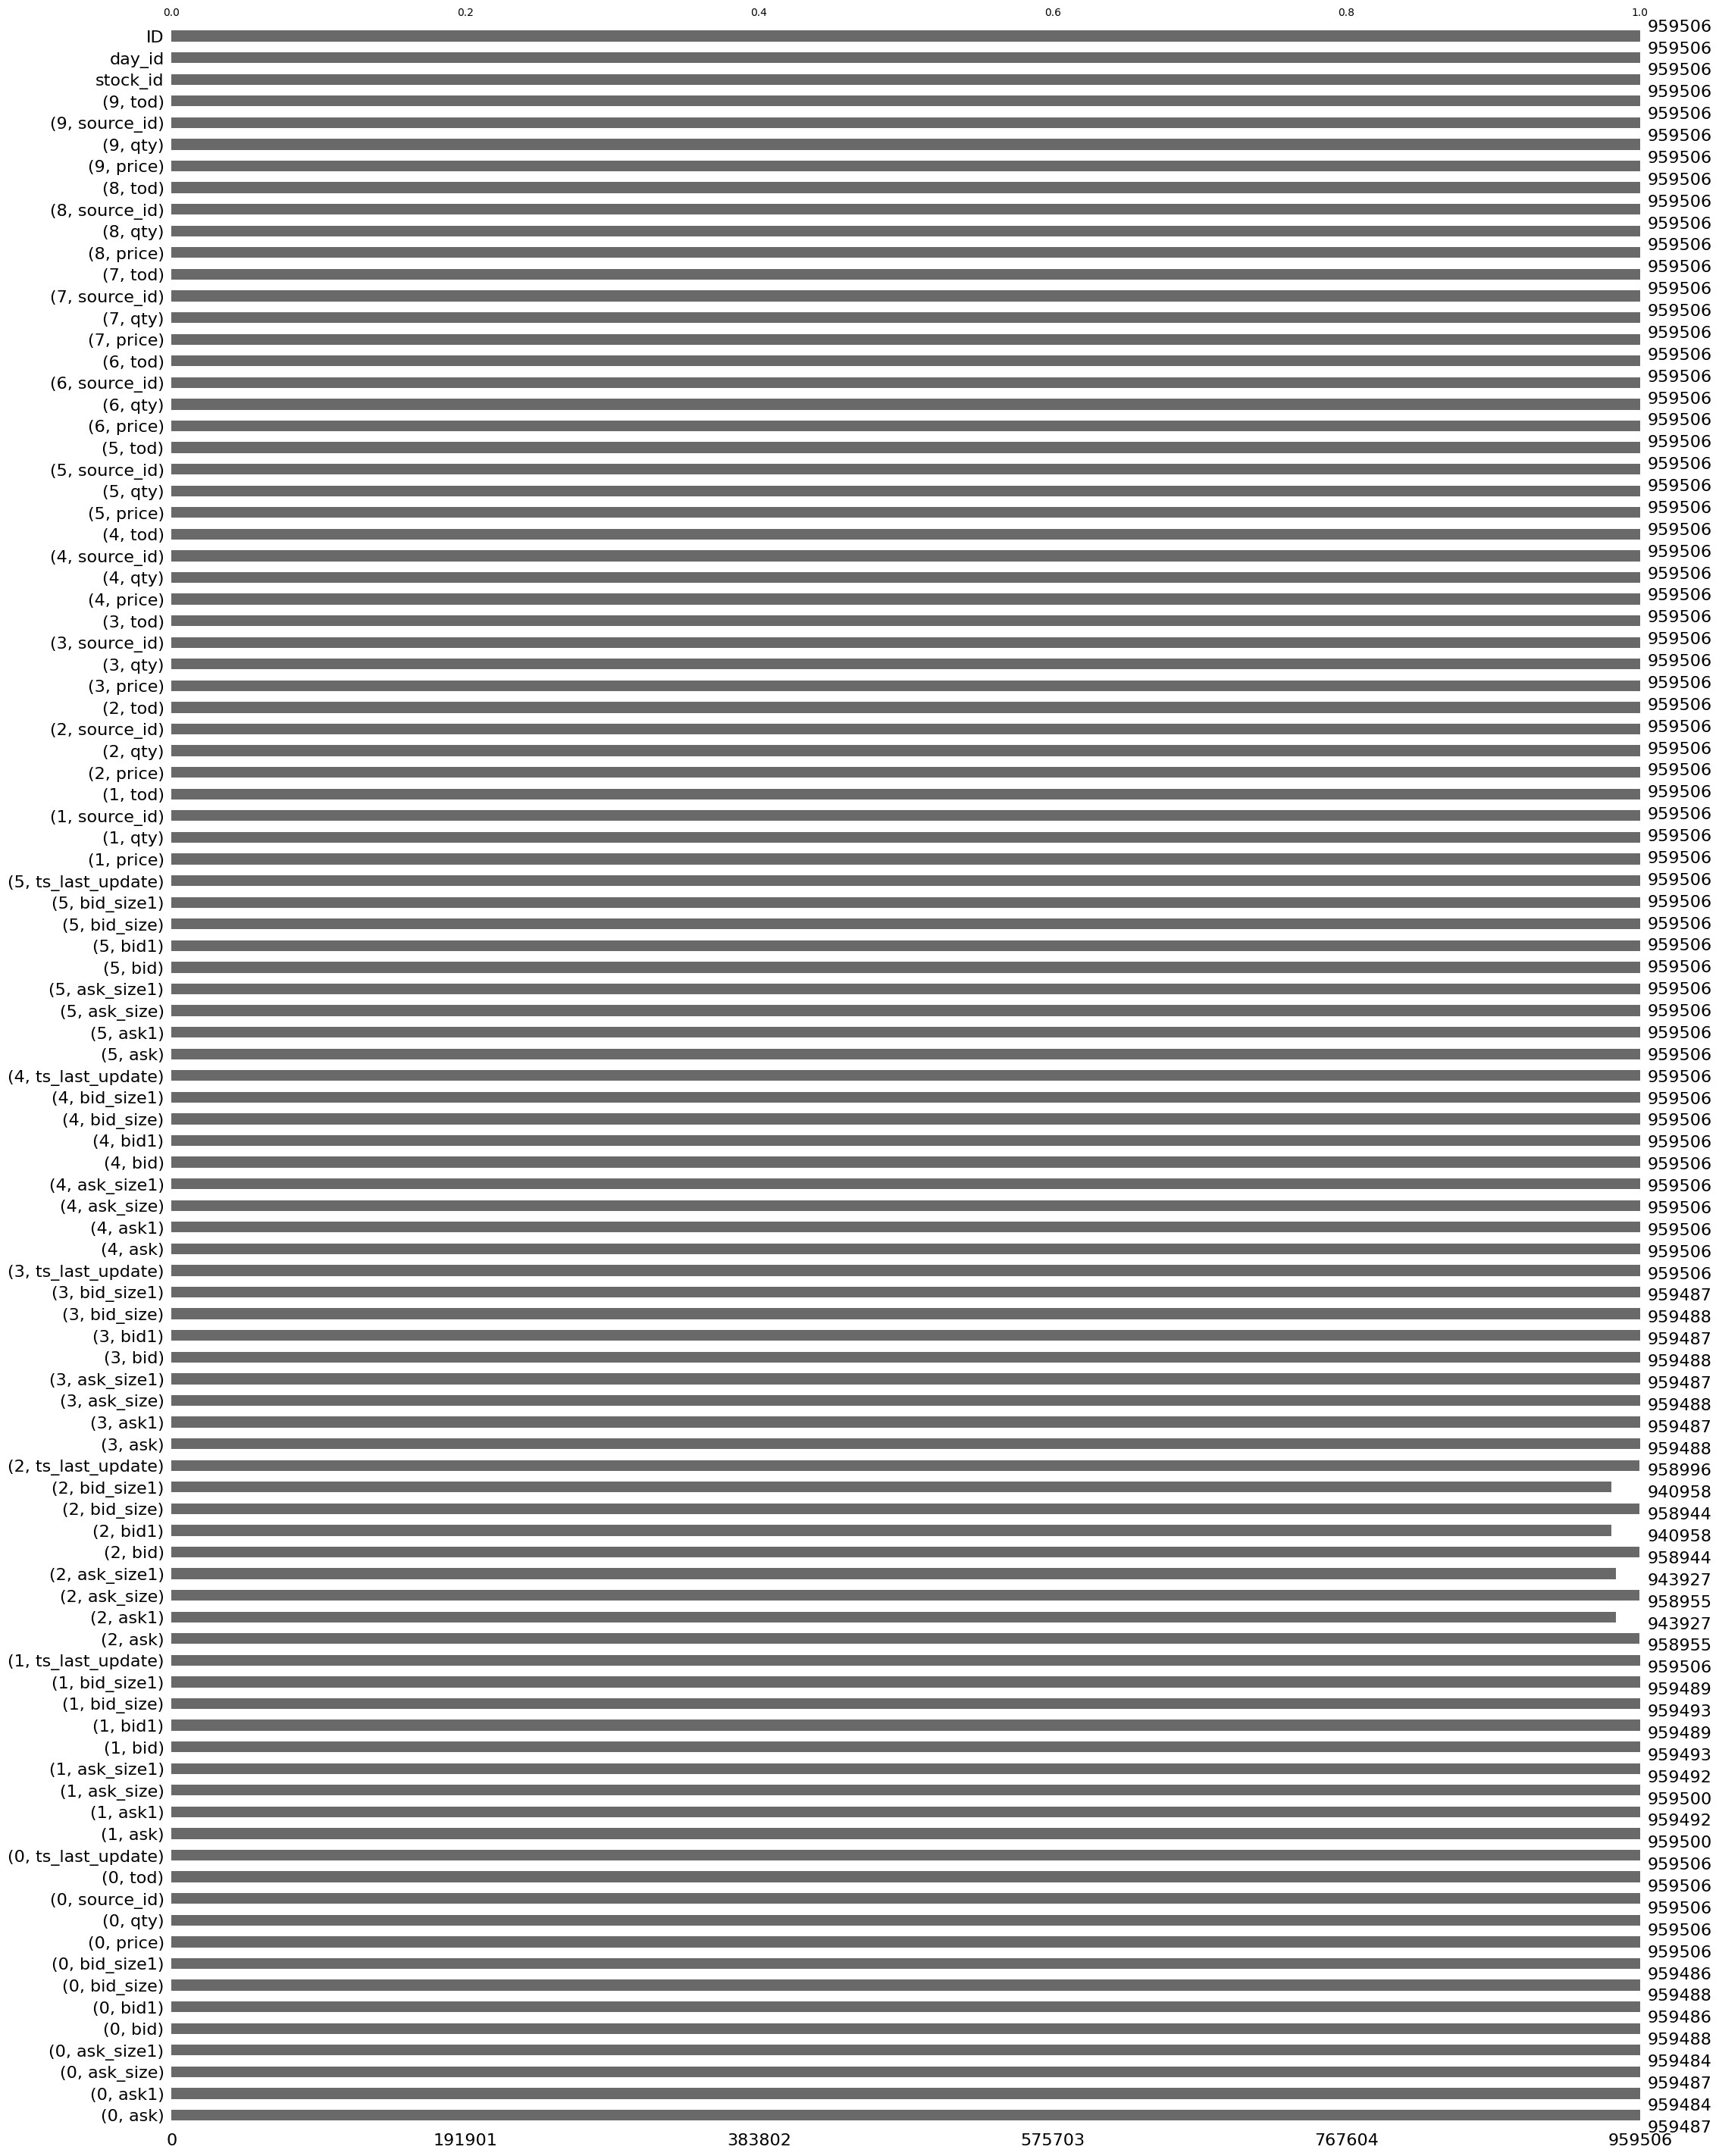

In [13]:
msno.bar(train)
plt.show()

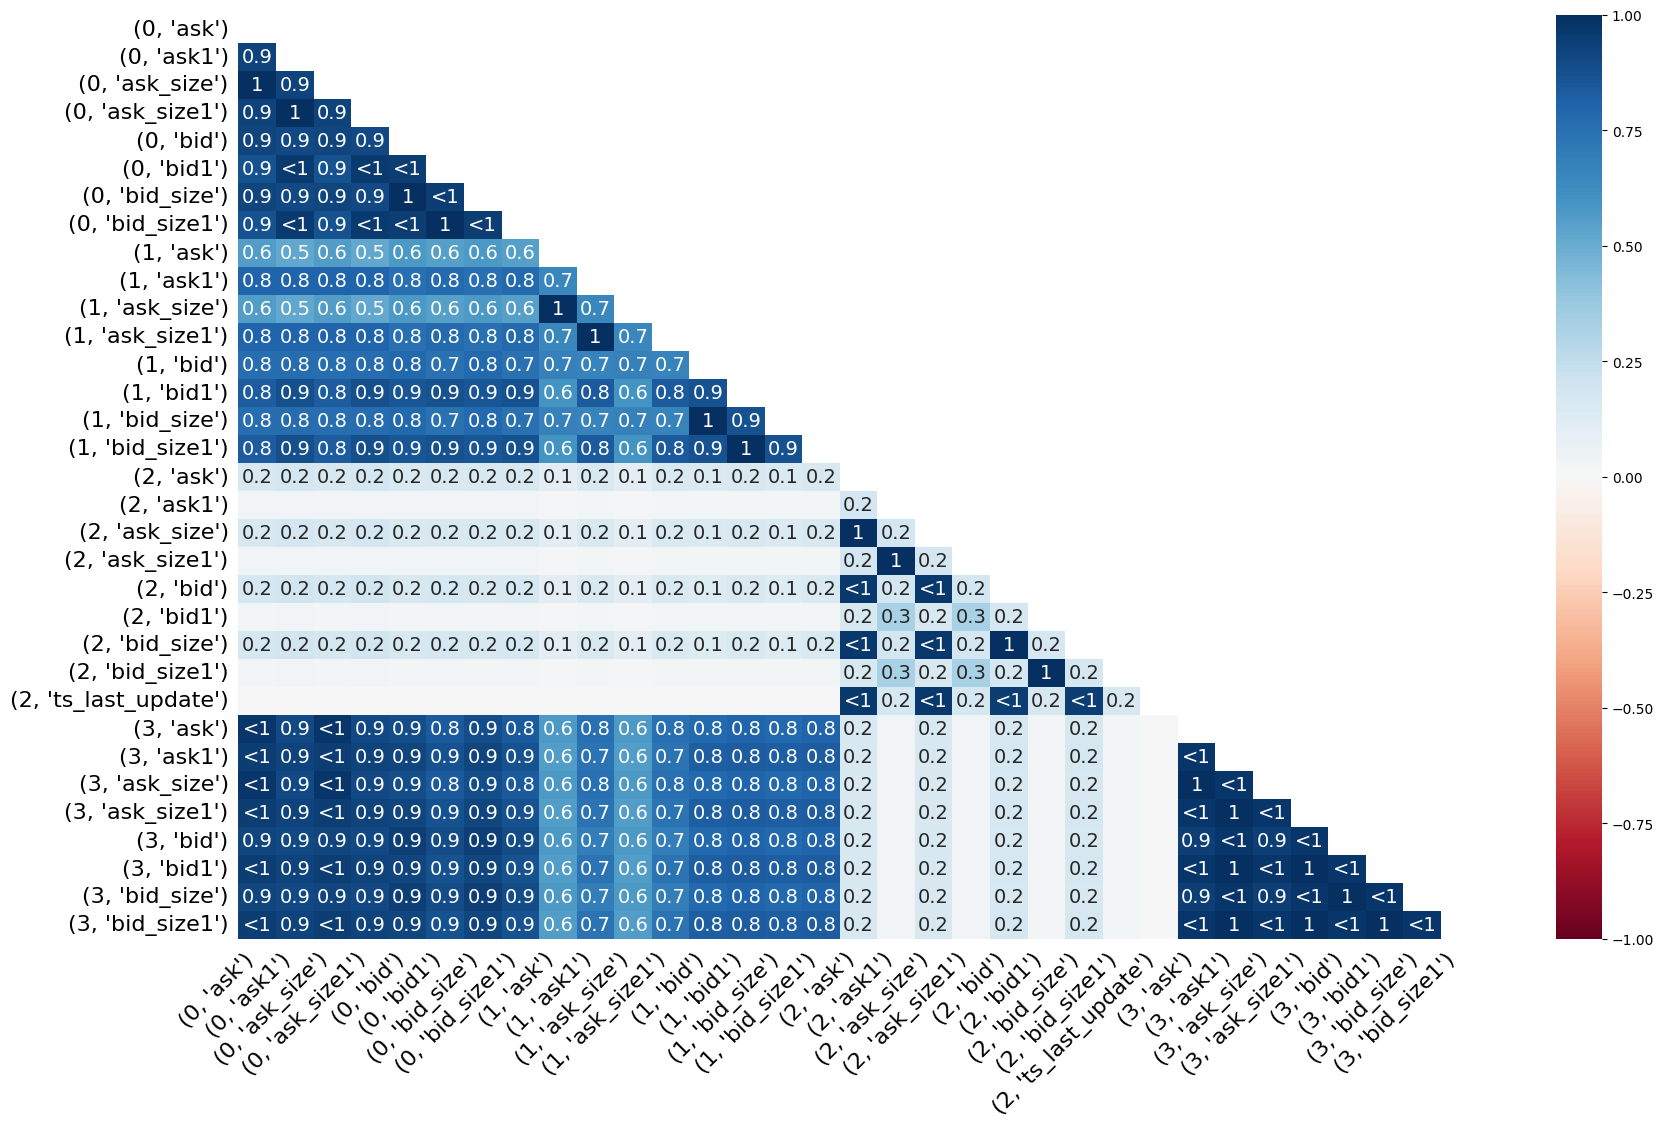

In [14]:
msno.heatmap(train)
plt.show()

El mapa de correlación mide la correlación de nulidad: la intensidad con que la presencia o ausencia de una variable afecta a la presencia de otra.

La correlación de nulidad oscila entre -1 (si una variable aparece, la otra definitivamente no) y 0 (las variables que aparecen o no aparecen no tienen ningún efecto entre sí) y 1 (si una variable aparece, la otra definitivamente también).

Las variables que están siempre llenas o siempre vacías no tienen una correlación significativa, por lo que se eliminan silenciosamente de la visualización.

Las entradas marcadas con <1 or >-1 tienen una correlación que está cerca de ser exactamente negativa o positiva, pero aún no lo es del todo. Esto apunta a un pequeño número de registros erróneos en el conjunto de datos. Estos casos requerirán una atención especial.

El mapa de calor funciona muy bien para detectar relaciones de integridad de datos entre pares de variables, pero su poder explicativo es limitado cuando se trata de relaciones más amplias y no es especialmente adecuado para conjuntos de datos extremadamente grandes.

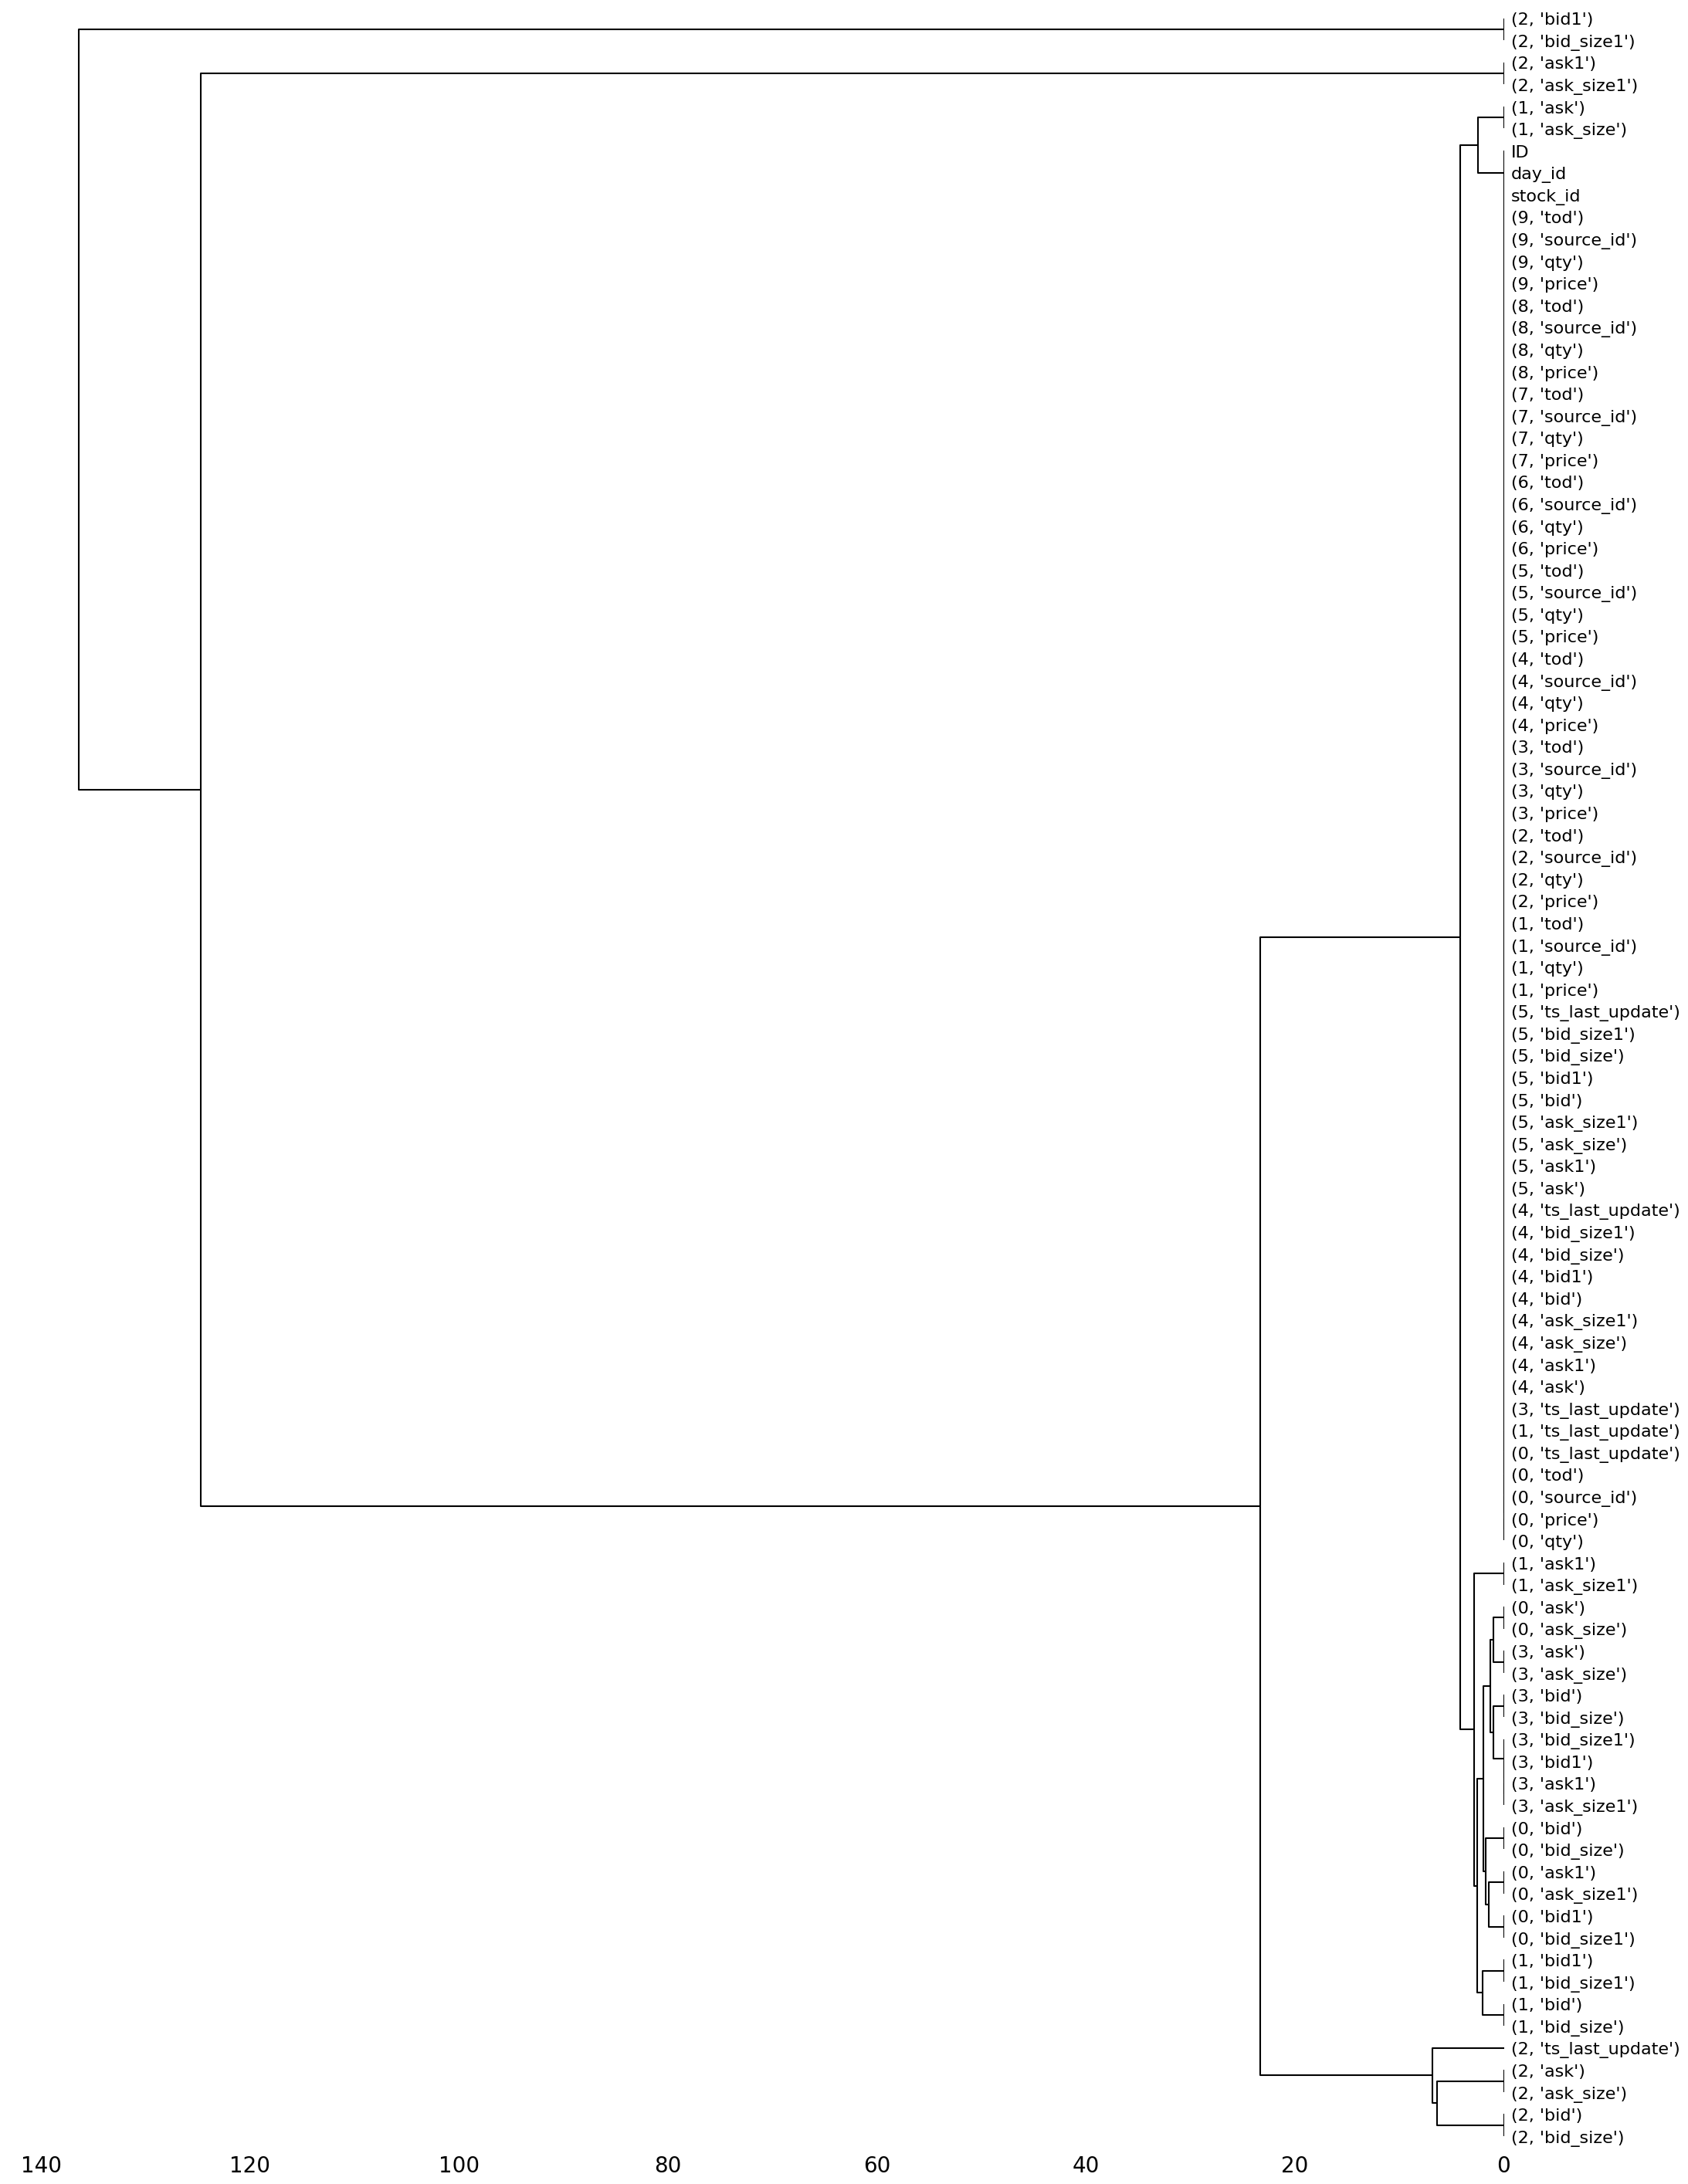

In [15]:
msno.dendrogram(train)
plt.show()

El dendrograma le permite correlacionar de forma más completa la finalización de las variables, revelando tendencias más profundas que las pares visibles en el mapa de calor de correlación.

El dendrograma utiliza un algoritmo de agrupación jerárquica para dividir las variables entre sí por su correlación de nulidad (medida en términos de distancia binaria). En cada paso del árbol, las variables se dividen en función de la combinación que minimiza la distancia de los conglomerados restantes. Cuanto más monótono sea el conjunto de variables, más se acercará su distancia total a cero, y más se acercará su distancia media (eje y) a cero.

Para interpretar este gráfico, veanlo desde una perspectiva descendente. Las hojas del dendrograma que están unidas a una distancia de cero predicen completamente la presencia de la otra: una variable puede estar siempre vacía cuando otra está llena, o ambas pueden estar siempre llenas o ambas vacías, y así sucesivamente. En este ejemplo concreto, el dendrograma une las variables necesarias y, por tanto, presentes en todos los registros.

Las hojas del dendrograma que se dividen cerca de cero, pero no en él, se predicen entre sí muy bien, pero de forma imperfecta. Si su propia interpretación del conjunto de datos es que estas columnas realmente son o deberían ser coincidentes entre sí en nulidad, entonces la altura de la hoja de conglomerados le indica, en términos absolutos, con qué frecuencia los registros están «desajustados» o incorrectamente archivados, es decir, cuántos valores tendría que rellenar o eliminar, si así lo desea.

Como en el caso de la matriz, en esta configuración sólo se mostrarán cómodamente hasta 50 columnas etiquetadas. Sin embargo, el dendrograma maneja de forma más elegante conjuntos de datos extremadamente grandes simplemente cambiando a una configuración horizontal.

In [16]:
# 2.1. Percent missing per column
missing_pct = train.isna().mean().sort_values(ascending=False)
display(missing_pct[missing_pct > 0].head(10))

# # 2.2. Heatmap of missingness (sample if data is huge)
# sns.heatmap(train.isna(), cbar=False, yticklabels=False)
# plt.title("Missing‑value heatmap (sampled)")
# plt.show()

(2, bid_size1)         0.019331
(2, bid1)              0.019331
(2, ask1)              0.016236
(2, ask_size1)         0.016236
(2, bid)               0.000586
(2, bid_size)          0.000586
(2, ask_size)          0.000574
(2, ask)               0.000574
(2, ts_last_update)    0.000532
(0, ask1)              0.000023
dtype: float64

In [18]:
# IQR‐based outliers (1.5×IQR)
iqr_summary = summarize_outliers(train, method="iqr", k=1.5)
print(iqr_summary)

            column  n_outliers  pct_outliers
74      (5, price)      214758     22.382142
70      (4, price)      187505     19.541827
90      (9, price)      166818     17.385821
66      (3, price)      161905     16.873787
86      (8, price)      152451     15.888488
..             ...         ...           ...
68  (3, source_id)           0      0.000000
69        (3, tod)           0      0.000000
72  (4, source_id)           0      0.000000
73        (4, tod)           0      0.000000
96              ID           0      0.000000

[97 rows x 3 columns]


In [19]:
# Z‐score based outliers (|z|>3)
z_summary = summarize_outliers(train, method="zscore", thresh=3)
print(z_summary)

            column  n_outliers  pct_outliers
50       (5, ask1)       19213      2.002385
28   (2, bid_size)       15358      1.600615
24   (2, ask_size)       15314      1.596030
38  (3, bid_size1)       15119      1.575707
34  (3, ask_size1)       14745      1.536728
..             ...         ...           ...
68  (3, source_id)           0      0.000000
69        (3, tod)           0      0.000000
72  (4, source_id)           0      0.000000
73        (4, tod)           0      0.000000
96              ID           0      0.000000

[97 rows x 3 columns]


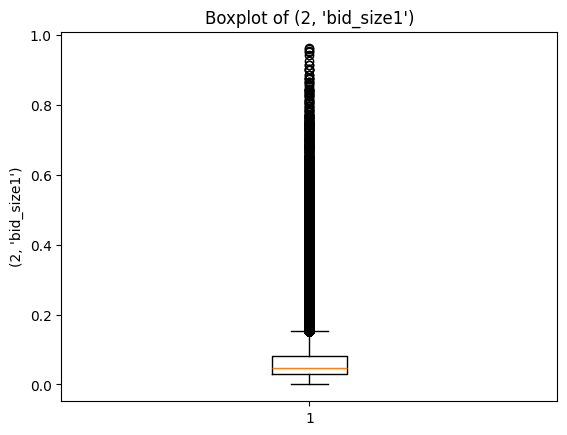

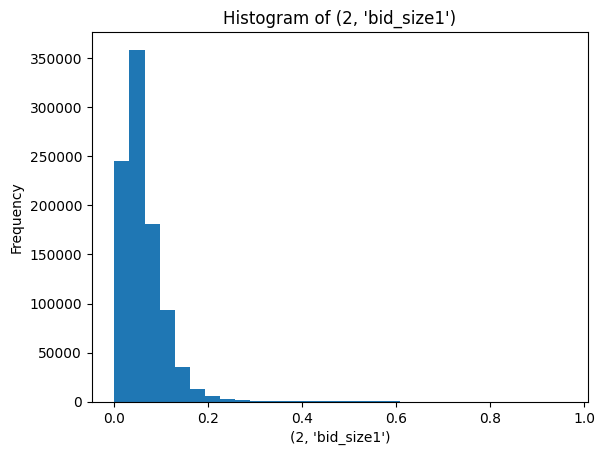

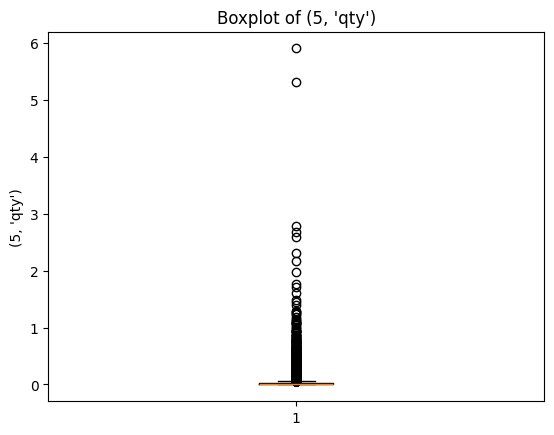

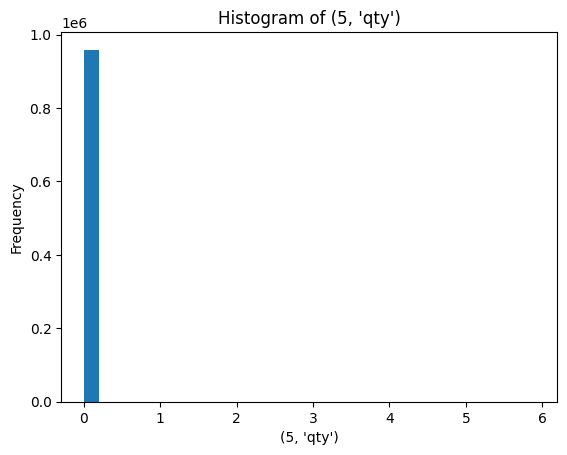

In [20]:
visualize_distributions(train, sample=2)

* **Distribución de los datos:** si están muy sesgados, IQR es más robusto que z-score.

* **Dimensionalidad:** para muchas características, métodos multivariados (LOF/IsolationForest).

* **Conocimiento del dominio:** a veces, los «valores atípicos» son sólo casos raros pero válidos.

### Analisis Multivariado

* **Distancia Mahalanobis:** Captura cuán lejos un punto está del promedio multivariado, considerando la covarianza

* **Métodos de Grafos:** Local Outlier Factor - Isolation Forest

* **Clustering**

![Lenguaje Matemático](./Images/Matematicas.png)

![Contacto](./Images/Contacto.png)